# 03-HOUSING EXAMPLE<img src="logo.png" style="float:right; max-width: 180px; display: inline" alt="logo" /></a>

# EMA housing maximum vibration stress variable power-law estimation model

*Originally written by Marc Budinger & Christophe Corsi, INSA Toulouse, France*<br>
*Adapted to illustrate pyVPLM application case*

## 1 - Introduction
<a id="1"></a>

The trend toward more electric aircraft face the problem with different engineering perspectives (bleedless, hydraulicless, electric-propulsion) to reduce operating costs (maintenance/fuel burn).<br>

<figure>
    <img src="./03_housing_example/ingenium_ema.jpg" alt="EMA_picture" style="height:200px">
    <figcaption>Fig.1 - Ingenium Aerospace EMA for a next generation space vehicle.</figcaption>
</figure>

Hydrauliless perspective consist in replacing hydraulic network by electric and actuation systems by electromechanical-actuators (EMAs). Yet housing mechanical sizing will now differ from hydraulic actuators that were facing:
- maximum stress to resist maximal pressure burst,
- stress due to buckling force and bending induced by rod-ends friction,
- fatigue when repeating some load cycles.

Since new embedded inertia (motor inertia/mass, roller-screw nut mass) will force designer to consider new design scenario:
- maximum stress induced by vibratory environment (5Hz-2kHz),
- stress indeuced by a maximum speed run-up till end-stops,
- additional shearing stress induced by roller-screw friction torque and motor.

<figure>
    <img src="./03_housing_example/ema_loads.png" alt="EMA_loads" style="height:200px">
    <figcaption>Fig.2 - EMA induced loads.</figcaption>
</figure>

We will illustrate in this notebook how we can construct estimation models to replace costly finite element structural vibration simulation of the EMA housing and more precisely produce an estimate of the maximum stress $\sigma$ as a function of geometry and material.<br>

<font color=blue>Table of contents:</font><br>
[1 - Introduction](#1-Introduction)<br>
[2 - Mechanical vibration FEM presentation](#2)<br>
[3 - Dimensional analysis](#3)<br>
[4 - Design of experiments](#4)<br>
[5 - Variable power-law model regression](#5)<br>
[6 - Use of the surrogate model](#6)<br>

> **Note**: to read more about EMA housing design [1] and dimensional analysis [2] consider reading following scientific papers:
- [1]: *Preliminary design of aerospace linear actuator housings*, Aircraft Engineering and Aerospace Technology: An International Journal,87,3,224-237, 2015, Emerald Group Publishing Limited
- [2]: *Dimensional analysis and surrogate models for the thermal modeling of Multiphysics systems*, Applied Thermal Engineering,110,758-771, 2017, Elsevier

## 2 - Mechanical vibration FEM presentation [§](#1)
<a id="2"></a>

We will analyze the vibratory loading problem using the following simplified geometry and assumptions: 
- 2 hollow cylinders for the housing made of steel (Young modulus $E$, density $\rho$, quality factor $Q_m$),
- 1 full cylinder for the nut (Young modulus $\frac{E}{10}$ not to participate in housing stiffness, density $\rho$, quality factor $Q_m$).

<figure>
    <img src="./03_housing_example/ema_FEM.png" alt="EMA_fem" style="height:300px">
    <figcaption>Fig.3 - EMA finite element model and equivalent 1D simplification.</figcaption>
</figure>

The maximal stress $\sigma$ is linked to the deplacement $U$:<br>
$ \sigma = k_\sigma *U= \sigma_0 *\frac{U}{U_0}$

And the stress can be expressed as follows:
$ \sigma = f(E,d_{rs},L_a,e_1,e_2,L_{rs})*U$

## 3 - Dimensional analysis [§](#1)
<a id="3"></a>

Let us apply Buckingham Theorem (from ***variablepowerlaw*** package) to highlight some dimensionless parameters and try to reduce problem parameters'number.

In [1]:
# Import pyVPLM modules/functions
from pyvplm.core.definition import PositiveParameter, PositiveParameterSet
from pyvplm.addon.variablepowerlaw import buckingham_theorem

# Declare physical variables and set
E_S = PositiveParameter('E_S', [210e9], 'Pa', 'steel Young modulus')
d_rs = PositiveParameter('d_rs', [10e-3, 100e-3],'m','roller-screw nut diameter')
e1 = PositiveParameter('e1', [5e-3, 40e-3], 'm', 'smaller diameter housing thikness')
e2 = PositiveParameter('e2', [1e-3, 10e-3], 'm', 'bigger diameter housing thikness')
RHO = PositiveParameter('RHO', [8.05], 'kg/m^3', 'steel density')
L_a = PositiveParameter('L_a', [0.1, 1.2], 'm', 'actuator length')
L_rs = PositiveParameter('L_rs', [3e-3, 100e-3], 'm', 'roller-screw nut length')
omega0 = PositiveParameter('omega0', [5, 2000], 'rad/s', 'angular resonance pulsation')
a = PositiveParameter('a', [0.1, 100], 'm/s^2', 'acceleration rate')
sigma = PositiveParameter('sigma', [1e6, 1e9], 'Pa', 'maximal constraint')
Q_M = PositiveParameter('Q_M', [2], '', 'quality factor')
parameter_set = PositiveParameterSet(E_S, d_rs, e1, e2, L_a, L_rs, RHO, omega0, a, sigma, Q_M)

# Define d and lambda_wind to be first elected as repetitive set
parameter_set.latex_render()

# Calculate pi parameters with first repetitive set found in parameters' order
pi_set, _ = buckingham_theorem(parameter_set, track=False)
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Some $\pi$ parameters arise in addition to geometric ratios:
- $\pi_{\omega_0}=\sqrt{\pi_4}=\omega_0 * d_{rs}*\sqrt{\frac{\rho}{E_S}}=f(\frac{l_a}{d_{rs}},\frac{l_{rs}}{d_{rs}},\frac{e_1}{d_{rs}},\frac{e_2}{d_{rs}})$
- $\pi_{\sigma}=\frac{\pi_5}{\pi_6}*Q_M=\frac{\rho*a*d_{rs}}{\sigma}*Q_M=g(\frac{l_a}{d_{rs}},\frac{l_{rs}}{d_{rs}},\frac{e_1}{d_{rs}},\frac{e_2}{d_{rs}})$


## 4 - Design of experiments [§](#1)
<a id="4"></a>

Considering previous dimensionless analysis and an homothetic sizing on roller-screw (meaning $\frac{l_{rs}}{d_{rs}}=cste$ term can be deleted), we will construct the design of experiment with remaining values: $e_1$, $e_2$, $d_{rs}$ and $L_a$.

Here we will retrieve the characteristic quantities of the problem and the calculated output in ***./03_housing_example/DataPI0_carter.csv*** file presenting 4 columns:
- the 1st column for the dependent variable $\pi_0=\pi_{sigma}$,
- the 3 other columns that correspond to $L_a/d$, $e_1/d$ and $e_2/d$ the independent quantities of the problem.

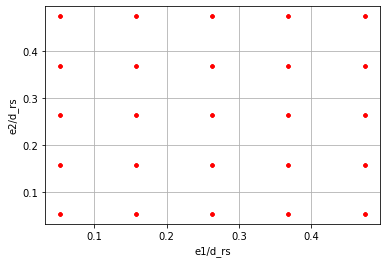

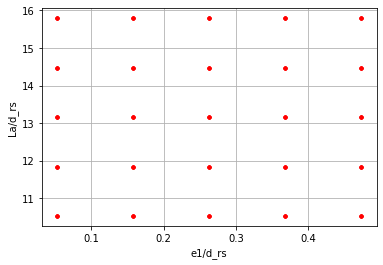

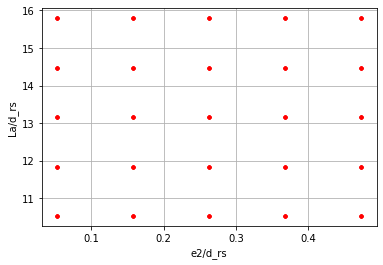

,pi0,La/d_rs,e1/d_rs,e2/d_rs
0,256.19,10.526316,0.052632,0.052632
1,302.56,11.842105,0.052632,0.052632
2,351.23,13.157895,0.052632,0.052632


In [2]:
# Change matplotlib visualisation parameter
%matplotlib inline

# Import additional libs
import pandas
import matplotlib.pyplot as plot

# Read the .csv file
df = pandas.read_csv('./03_housing_example/dataPI0_carter.csv', sep=';')

# Print DOE
plot.plot(df['e1/d_rs'],df['e2/d_rs'],'r.')
plot.xlabel('e1/d_rs')
plot.ylabel('e2/d_rs')
plot.grid(True)
plot.show()
plot.plot(df['e1/d_rs'],df['La/d_rs'],'r.')
plot.xlabel('e1/d_rs')
plot.ylabel('La/d_rs')
plot.grid(True)
plot.show()
plot.plot(df['e2/d_rs'],df['La/d_rs'],'r.')
plot.xlabel('e2/d_rs')
plot.ylabel('La/d_rs')
plot.grid(True)
plot.show()

# Print the head (first lines of the file)
df.head(n=3)

## 5 - Variable power-law model regression [§](#1)
<a id="5"></a>

The dependant variable will be approximated here with a linear regression on 2nd order power-law model of the following form: 

$log(\pi_0) = a_0 + \sum\limits a_ilog(\pi_i) + \sum\limits a_{ij}log(\pi_{i})log(\pi_{j}) + \sum\limits a_{ii}log(\pi_i^2)$  

Which can be rewritten as:  

$\pi_0 = 10^{a_0}\prod\limits_{i=1}^{n} \pi_i^{a_i + a_{ii}log(\pi_{i}) + \sum\limits_{j=i+1}^{n} a_{ij}log(\pi_{j})} $  

This variable power law form enables to deal with large variation range of dependant and independant variables. 

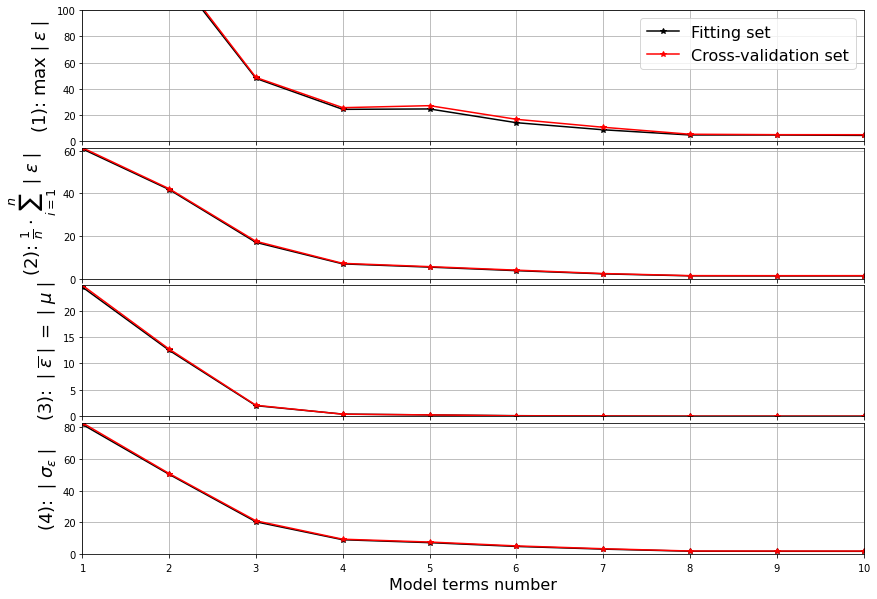

In [3]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models

# Fit with 2nd order model the obtained Pi DOE
doePI = df.values
models = regression_models(doePI, elected_pi0='pi1', order=2, test_mode=True)

> **Note**: A way to check the quality of the regression model is to compare the $\pi_0$ data resulting from FEM simulation to the evaluation of the surrogate model. A perfect surrogate model will look like a $y=x$ curve.
To do so, we have to use ***variablepowerlaw.perform_regression*** method.    


Elected model for regression is n°4:


<IPython.core.display.Latex object>

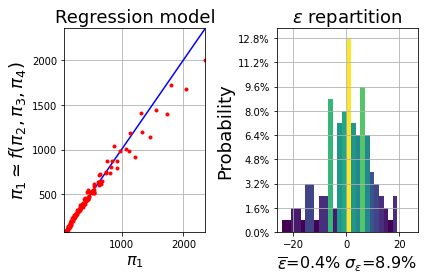

In [4]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import perform_regression

# Plot advanced result for model n°4
expression, expression_latex = perform_regression(doePI, models, chosen_model=4)

## 6 - Use of the surrogate model [§](#1)
<a id="6"></a>

We illustrate here the use of the created surrogate model n°10 to estimate the maximum induced stress on given geometry.

In [5]:
# Import additional libs
from numpy import log10

# Define geometry an material
d_rs = 0.09#[m] roller-screw nut diameter
la = .9#[m] actuator length
e1 = 0.01#[m] Road thickness
e2 = 0.005#[m] Housing thickness
Qm=30#[-] Mechanical quality coef
rho=7800#[kg/m^3] Volumic mass
a=20*9.8#[m/s^2] Acceleration

# Pi calculation
pi2 = la/d_rs
pi3 = e1/d_rs
pi4 = e2/d_rs
expression = '10**(1.28187-0.60263*log10(pi3)+0.80237*log10(pi4)+0.83024*log10(pi2)+0.40250*log10(pi2)**2+0.07760*log10(pi2)*log10(pi4)+0.08495*log10(pi2)*log10(pi3)+0.27216*log10(pi4)**2+0.13195*log10(pi3)**2-0.21442*log10(pi3)*log10(pi4))'
pi1 = eval(expression)
sigma = pi1*Qm*d_rs*rho*a

# Display result
print("Estimated max stress is: %.0f MPa"%(sigma/1e6))

Estimated max stress is: 648 MPa
